# Posterior GP kernel on a regression task

This tutorial follows the `laplace-torch` regression tutorial. It is a great start to visually understand the posterior Gaussian Process kernel induced by the weight-space Laplace approximation.

In [1]:
import jax
import jax.numpy as jnp
import optax
from flax import nnx
from helper import get_sinusoid_example
from plotting import plot_regression_with_uncertainty

n_epochs = 1000
key = jax.random.key(0)

# Sample toy data example
num_training_samples = 150
batch_size = 20
X_train, y_train, train_loader, X_test = get_sinusoid_example(
    num_data=num_training_samples, sigma_noise=0.3, batch_size=batch_size
)

## Training a MAP

In this tutorial, we use `flax.nnx` for training a neural network. Other libraries (e.g., `equinox` or `flax.linen`) should also work out of the box if you can bring them in the form of a separate `model_fn` function (taking two arguments, `inputs` and `params`), and a `params` PyTree containing the learned parameters you want to do inference over.

In [2]:
# Create and train MAP model
class Model(nnx.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, rngs):
        self.linear1 = nnx.Linear(in_channels, hidden_channels, rngs=rngs)
        self.tanh = nnx.tanh
        self.linear2 = nnx.Linear(hidden_channels, out_channels, rngs=rngs)

    def __call__(self, x):
        x = self.linear1(x)
        x = self.tanh(x)
        x = self.linear2(x)
        return x


# Initialize model
model = Model(in_channels=1, hidden_channels=50, out_channels=1, rngs=nnx.Rngs(0))


# Set loss function
def criterion(x, y):
    return jnp.mean((x - y) ** 2)


# Create optimizer
optimizer = nnx.Optimizer(model, optax.adamw(1e-3))  # Reference sharing


@nnx.jit
def train_step(model, optimizer, x, y):
    def loss_fn(model):
        y_pred = model(x)  # Call methods directly
        return criterion(y, y_pred)

    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(grads)  # Inplace updates

    return loss

In [3]:
for _ in range(500):
    for x_train, y_train in train_loader:
        loss = train_step(model, optimizer, x_train, y_train)
        print("loss:", loss, end="\r")

## Setup Full Laplace

In [4]:
from laplax.curv import create_ggn_mv
from laplax.util.loader import input_target_split

# Create GGN
graph_def, params = nnx.split(model)


def model_fn(input, params):
    return nnx.call((graph_def, params))(input)[0]


train_batch = input_target_split(next(iter(train_loader)))
ggn_mv = create_ggn_mv(
    model_fn,
    params,
    train_batch,
    loss_fn="mse",
    # num_total_samples=num_training_samples,
)

In [5]:
from laplax.curv.cov import create_posterior_fn

# Create Posterior
posterior_fn = create_posterior_fn(
    "full",
    mv=ggn_mv,
    layout=params,
    key=jax.random.key(20),
)

## Setup Posterior GP Kernel

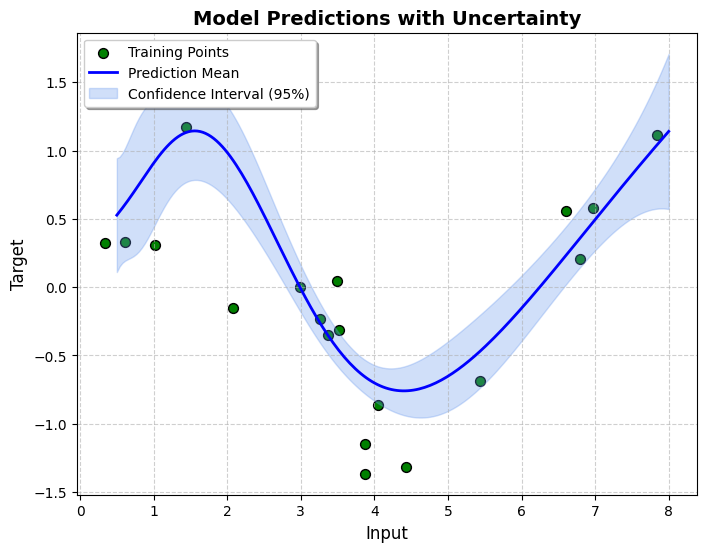

In [6]:
from laplax.eval.pushforward import set_posterior_gp_kernel

prior_arguments = {"prior_prec": 0.3}

gp_kernel, dist_state = set_posterior_gp_kernel(
    model_fn=model_fn,
    mean=params,
    posterior_fn=posterior_fn,
    prior_arguments=prior_arguments,
    dense=True,  # If dense = False, then a kernel-vector product is returned.
    output_layout=1,
)

X_grid = jnp.linspace(0.5, 8, 200).reshape(200, 1)
Y_pred = model_fn(X_grid, params)[:, 0]

Y_var = jax.vmap(lambda x: gp_kernel(x, x))(X_grid)[:, 0, 0]

plot_regression_with_uncertainty(
    train_input=train_batch["input"],
    train_target=train_batch["target"],
    X_grid=X_grid,
    Y_pred=Y_pred,
    Y_var=Y_var,
)

## Setup Low Rank Laplace

In [7]:
from laplax.curv.cov import create_posterior_fn

# Create Posterior
posterior_fn = create_posterior_fn(
    "low_rank",
    mv=ggn_mv,
    layout=params,
    key=jax.random.key(20),
    maxiter=50,
    mv_jittable=True,
)

/Users/balint/Documents/laplax/laplax/curv/low_rank.py:140: UserWarning: reduced maxiter to 29 due to insufficient size
  warnings.warn(msg, stacklevel=1)


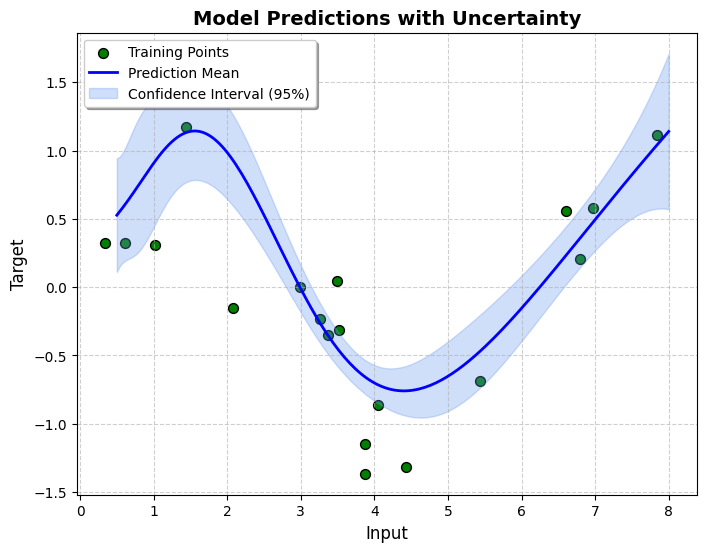

In [8]:
from laplax.eval.pushforward import set_posterior_gp_kernel

prior_arguments = {"prior_prec": 0.3}

gp_kernel, _ = set_posterior_gp_kernel(
    model_fn=model_fn,
    mean=params,
    posterior_fn=posterior_fn,
    prior_arguments=prior_arguments,
    dense=True,  # If dense = False, then a kernel-vector product is returned.
    output_layout=1,
)

X_grid = jnp.linspace(0.5, 8, 200).reshape(200, 1)
Y_pred = model_fn(X_grid, params)[:, 0]

Y_var = jax.vmap(lambda x: gp_kernel(x, x))(X_grid)[:, 0, 0]

plot_regression_with_uncertainty(
    train_input=train_batch["input"],
    train_target=train_batch["target"],
    X_grid=X_grid,
    Y_pred=Y_pred,
    Y_var=Y_var,
)